# Analysis of MD simulations of Protein Crystals - Bragg

$\text{David Wych}^{1, 2}, \text{Michael E. Wall}^{1}$

1. Computer, Computational and Statistical Sciences Division, Los Alamos National Laboratory, Los Alamos, NM 87545, USA
2. Center for Nonlinear Studies, Los Alamos National Laboratory, Los Alamos, NM 87545, USA

## Generating Bragg data from a crystalline MD trajectory

In the notebook "Analysis of MD Simulations of Protein Crystals -- Diffuse", we show how to compute structure factors from an MD simulation trajectory. The lunus script `xtraj.py` takes in a `GROMACS` `.xtc` trajectory file and a topology file (in the `.pdb` format) and computes the structure factors. To produce structure factors that can be compared with those from experiment, one needs to supply `unit_cell` and `space_group` information from the `CRYST1` record of the crystal structure, and the computed structure factors are transformed to match the structure of those that would be measured in experiment.

In that notebook, we were working with data from a simulation of _staphylococcal nuclease_. So, the `fcalc.mtz` structure factor files we produced in that notebook could be used as a complement to analysis of the structure and dynamcis of _that_ system. In this notebook, were going to be using a different dataset, produced from a crystalline MD simulation of _protein kinase A_. This data will be used to reproduce some of the findings from our paper, published in _Acta Crystallographica Section D_ entitled "[Molecular Dynamics Simulation Methods for Macromolecular Crystallography](https://journals.iucr.org/d/issues/2023/01/00/lp5065/)".

In this notebook, we'll cover:

- Refining a structural model against data computed from an MD simulation of a crystalline protein system.
- Analyzing the B-factors from the simulated trajectory, and the model refined against the MD data (with some caveats concerning restrained and unrestrained simulation).
- Reverse propagating a supercell simulation frame to produce a protein structural ensemble that can be used to complement the Bragg analysis.

---

We can use the `fcalc.mtz` file produced by `lunus`' `xtraj.py` to calculate the Bragg scattering intensities from our MD trajectetory. Below is an example script that takes in a `fcalc.mtz` file and produces an `iobs.mtz` intensity data file, with the intensities (squared structure factors) and variances (10 times the intensities themselves) in columns 1 and 2.

```bash
#!/usr/bin/env bash
# generate_iobs.sh
#
# The first argument, $1, is the structure factor mtz file
# The second arguement, $2 is the name of the output file
if [ -e iobs.mtz ]; then
  rm iobs.mtz
fi

sftools <<EOF
read $1
calc J col Iobs = col 1 col 1 * 100. /
calc Q col SIGIobs = col 1 10. /
write $2
quit
EOF

```

In [1]:
%%capture
!bash ./code/generate_iobs.sh data/fcalc_full.mtz iobs_full.mtz
!bash ./code/generate_iobs.sh data/fcalc_wat.mtz iobs_water.mtz
!bash ./code/generate_iobs.sh data/fcalc_prot.mtz iobs_protein.mtz

In [2]:
!mv iobs_full.mtz files_for_refinement/
!mv iobs_water.mtz files_for_refinement/
!mv iobs_protein.mtz files_for_refinement/

## Refinining a structure against MD data

It is possible to refine a protein structure against the data computed from the MD trajectory in exactly the same way as one would refine a structure against experimental data.

We use `phenix` to perform this refinement. In the refinement parameter definition `.eff` file, we specify the `iobs_protein.mtz` or `iobs_full.mtz` files as the X-ray data for refinement, and we use the `starting_structure.pdb` file as the starting structural model.

The data we're going to be working with comes from our recent _Acta Cryst. D._ publication, "Molecular Dynamics Simulations for Macromolecular Crystallography". These `.mtz` files were calcualted from the 90-100ns segment of a crystalline MD simulation of _protein kinase A_ (PKA).

If we want to argue that the MD can provide information that is useful to crystallographic refinement, first we need a control to compare to. 

Below, we just refine the starting structure against the experimental data
- the flag `--unused_ok` just tells phenix that if there are any refinement parameters we aren't defining in the `.eff` file, that's ok

In [3]:
%%capture
!phenix.refine ./files_for_refinement/single_structure_refinement.eff --unused_ok;

The main statistic tracked in refinement is the "R-factor", $R$ (which stands for "residual factor" or "reliability factor). It's computed by comparing the observed structure factors ($F_{\text{obs}}$) and calculted structure factors ($F_{\text{calc}}$) with the following formula:

$$ R = \dfrac{\sum ||F_{\text{obs}}| - |F_{\text{calc}}||}{\sum |F_{\text{obs}}|}. $$

That is, the absolute sum of the disagreement between the observed and calculated structure factors, as a percentage of the total sum of the absolute value of all the observed structure factors. So, an R-factor of 0 corresponds to perfect aggreement between the calculated and observed structure factors. An R-factor of 0.2 indicates a (roughly) 20% error in the calculated structure factors, on average.

To protect against overfitting to the experimental data, a random "free" subset of the structure factors (usually 10% of all the structure factors) are set aside for validation. The refinement uses only the "working" subset (the other 90%) of structure factors to test whether there have been improvements of the model, and the R-factor is computed for the "free" subset ($R_{\text{free}}$) after the modeling changes to test whether the refinement is overfitting to the data. Usually, $R_{\text{free}} > R_{\text{work}}$ because the refinement is performed with respect to the "working" subset, completely independent of the agreement with the "free" subset.

For context, the average $R_{\text{free}}$ for the structures in the Protein Data Bank is [between 23 and 24%](https://www.rcsb.org/stats/distribution-r-free). An $R_{\text{free}}$ < 15%  is considered very good.

---

Let's look at the R-factors for our refinement of our structure against the experimental data:

In [4]:
!tail -n 7 starting_structure_refinement_against_experiment_1.log

=========================== phenix.refine: finished ===========================

# Date 2023-03-29 Time 09:53:28 MDT -0600 (1680105208.63 s)

Start R-work = 0.1903, R-free = 0.2144
Final R-work = 0.1570, R-free = 0.1859
wall clock time: 355.35 s


Next, we're going to refine the same starting structure against the Bragg data computed from only the protein atoms in the trajectory. We turn of ordered water modeling (water picking and refinement), and bulk solvent and scaling, so that we are only refining the protein structure and nothing else.

In [5]:
%%capture
!phenix.refine ./files_for_refinement/refine_protein.eff --unused_ok;

In [6]:
!tail -n 7 single_structure_protein_only_refine_1.log

=========================== phenix.refine: finished ===========================

# Date 2023-03-29 Time 10:00:53 MDT -0600 (1680105653.17 s)

Start R-work = 0.4275, R-free = 0.3965
Final R-work = 0.2378, R-free = 0.2327
wall clock time: 441.19 s


Next, we refine against the full MD Bragg data, including the scattering from the solvent. However, we do this refinement in two stages. In the first stage we do two macrocycles of ordered solvent modeling (water picking) with no refinement of structure for either the protein atoms or added water atoms. Then we do a second refinement for three macrocycles, refining sites and ADPs, with water picking turned off.

In [7]:
%%capture
!phenix.refine ./files_for_refinement/refine_waters.eff --unused_ok
# Need to rename the *_data.mtz file or else the second refinement won't run
!mv single_structure_protein_first_waters_refine_data.mtz single_structure_protein_first_waters_refine_data_1.mtz

In [8]:
%%capture
!phenix.refine ./files_for_refinement/refine_waters_2.eff --unused_ok

In [9]:
!tail -n 7 single_structure_protein_first_waters_refine_2.log

=========================== phenix.refine: finished ===========================

# Date 2023-03-29 Time 10:08:08 MDT -0600 (1680106088.18 s)

Start R-work = 0.2025, R-free = 0.2105
Final R-work = 0.1398, R-free = 0.1608
wall clock time: 306.47 s


Finally, we refine the full model we just prepared (refined against the MD data) against the exerimental data. Notice that the R-factors for this refinement are lower than those that we achieved by refinining the starting structure against the experimental data. The MD data is providing information that makes our model agree better with teh experimental data than just refinement alone.

In [10]:
%%capture
!phenix.refine ./files_for_refinement/refine_against_exp.eff --unused_ok

In [11]:
!tail -n 7 single_structure_protein_first_refinement_against_exp_1.log

=========================== phenix.refine: finished ===========================

# Date 2023-03-29 Time 10:13:23 MDT -0600 (1680106403.39 s)

Start R-work = 0.2192, R-free = 0.2189
Final R-work = 0.1395, R-free = 0.1747
wall clock time: 311.83 s


Compare these final R-factors with those from our initial single structure refinement against the experimental data. Note that the refinement parameters for this last refinement are identical to those used for the initial single structure refinement (same number of macrocycles, same strategies, etc.) except that ordered water placement and refinement have been turned off (we already placed and refined the ordered waters in the refinement against the MD data, and we'd like to keep those waters). So, the only difference is the structure fed in to the refinement. In the final case, the structure has been changed by refinement against the MD data, and in doing so, the R-free has improved by a little over 1%.

---

There are a few explanations for how our MD revised model is performing better than the single structure refinement alone. The first and most obvious is just that the coordinates of the protein atoms are different. To examine this assumption, we can compute the root-mean-square deviation (RMSD) of the atomic coordiantes for the proteins from the various models. For two sets of atomic coordinates $\mathbf{V} = \{\mathbf{v}_1,\mathbf{v}_2, \mathbf{v}_3, \dots \mathbf{v}_N\}$ and $\mathbf{W} = \{\mathbf{w}_1,\mathbf{w}_2, \mathbf{w}_3, \dots \mathbf{w}_N\}$ the RMSD is computed as:

$$ \mathrm{RMSD}(\mathbf{W}, \mathbf{V}) = \sqrt{ \frac{1}{N} \sum_n ((w_{x,n} - v_{x,n})^{2} + (w_{y,n} - v_{y,n})^{2} + (w_{z,n} - v_{z,n})^{2})}$$

The RMSD gives a measure of the average distance between the atoms in the two models.

In [12]:
import iotbx.pdb
import numpy as np

initial = iotbx.pdb.input(file_name="starting_structure_refinement_against_experiment_1.pdb").construct_hierarchy()
MD_revised = iotbx.pdb.input(file_name="single_structure_protein_first_waters_refine_2.pdb").construct_hierarchy()
final   = iotbx.pdb.input(file_name="single_structure_protein_first_refinement_against_exp_1.pdb").construct_hierarchy()

def get_rmsd(first, second):
    def get_coords(hierarchy):
        atoms = []
        for chain in hierarchy.chains():
            for res in chain.residues():
                if res.resname not in ["HOH","MG", "ADP", "PO4"]:
                    for atom in res.atoms():
                        atoms.append(atom)
        
        return np.array([atom.xyz for atom in atoms])
    
    dist_sq = np.sum(np.power(np.subtract(get_coords(first), get_coords(second)),2), axis=1)
    RMSD = np.sqrt(np.mean(dist_sq))
    return RMSD
          

print("Protein atom RMSD between the initial single structure model and the model refined against MD data: {:.3f} A".format(get_rmsd(initial, MD_revised)))
print("Protein atom RMSD between the initial single structure model and the final MD model: {:.3f} A".format(get_rmsd(initial, final)))

Protein atom RMSD between the initial single structure model and the model refined against MD data: 0.776 A
Protein atom RMSD between the initial single structure model and the final MD model: 0.760 A


So, the protein atoms of the model refined against the MD data are different from the atoms in the initial single structure refinement by less than an angstrom on average. And the RMSD between the initial single structure refined model and the MD model refined against the same experimental data is, predictably, even smaller (though only slightly). For context, a carbon-hydrogen bond is about an angstrom. There must be something else then that explains why the MD model agrees better with the experimental data than the model with no MD data incorporated...

---

Much of the difference here comes from the ordered solvent model -- the MD model contains many more water molecules than the refinemnet against experiment. Below we compute the number of water molecules in the original structure refined against the experimental data, and the structure from the refinement against the MD data.

In [13]:
!grep -c HOH starting_structure_refinement_against_experiment_1.pdb
!grep -c HOH single_structure_protein_first_refinement_against_exp_1.pdb

146
429


The MD-informed model has almost three times as many waters! 

We argue, [in our paper on these methods](https://journals.iucr.org/d/issues/2023/01/00/lp5065/lp5065.pdf), that the MD data provides a means by which to produce an alternative ordered solvent model to the one produced by water picking and refinement in standard methods, which improves the agreement with the experimental data.

Below is a figure from the Supporting Information from that paper, showing the differences in the ordered water networks for **(A)** the initial single structure model and **(B)** the final MD-revised model (which, in the paper, also includes some additional modeling, including multiconformer residues inferred from the reverse-propagated ensemble from the simulation, which we will discuss below).

![water comparison](./images/water_comparison.png)

## B-factors

One of the parameters refined in a structural model is the anisotropic displacement parameter, or ADP. This is a measure of the small-scale harmonic disorder associated with each atom in the model. In the case of isotorpic ADP's (modeling the small scale harmonic disorder as the same in all directions) this is called a "B-factor", and it shows up as the last column for each `ATOM` or `HETATM` record.

Let's look at the average B-factor of each residue in our models:

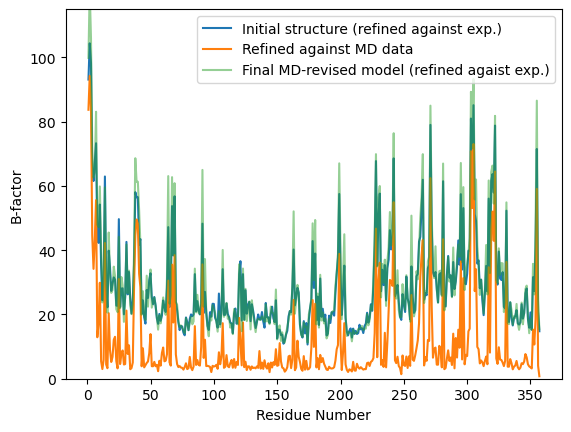

In [14]:
import matplotlib.pyplot as plt
import numpy as np

initial = iotbx.pdb.input(file_name="starting_structure_refinement_against_experiment_1.pdb").construct_hierarchy()
MD      = iotbx.pdb.input(file_name="single_structure_protein_first_waters_refine_2.pdb").construct_hierarchy()
final   = iotbx.pdb.input(file_name="single_structure_protein_first_refinement_against_exp_1.pdb").construct_hierarchy()

def get_bfacs(hierarchy):
    bfacs = []
    for chain in hierarchy.chains():
        for res in chain.residues():
            if res.resname not in ["HOH","MG", "ADP", "PO4"]:
                bfac  = 0
                atoms = 0
                for atom in res.atoms():
                    bfac += atom.b
                    atoms += 1
                bfacs.append(bfac/atoms)
    
    return bfacs
    
initial_bfactors = get_bfacs(initial)
MD_bfactors = get_bfacs(MD)
final_bfactors = get_bfacs(final)
    
plt.plot(np.arange(len(initial_bfactors))+1,np.array(initial_bfactors), label="Initial structure (refined against exp.)")
plt.plot(np.arange(len(MD_bfactors))+1,np.array(MD_bfactors), label="Refined against MD data")
plt.plot(np.arange(len(final_bfactors))+1,np.array(final_bfactors), alpha=0.5, label="Final MD-revised model (refined agaist exp.)")
plt.ylim([0,115])
#plt.xlim([1,370])
plt.xlabel("Residue Number");
plt.ylabel("B-factor");
plt.legend();

So, as we might expect from how similar the coordinates of the structural models are, the B-factors for both of the refinements against experimental data seem pretty similar. 

But...

Wow, those B-factors for the model refined against MD data seem pretty low... What's going on there?

Well, the PKA simulation from which we computed the structure factors was _restrained_ to the crystal structure, so the fluctuations of all the heavy atoms are suppressed by the restraints! 

Let's compare with the B-factors from a structure that was refined against the MD data in exactly the same way, but using structure factors computed from a simulation that was *unrestrained*.

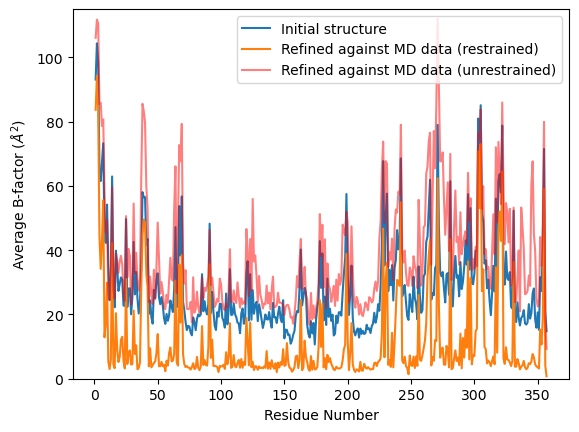

In [15]:
final_unrestrained = iotbx.pdb.input(file_name="./data/unrestrained_single_structure_protein_first_waters_refine_2.pdb").construct_hierarchy()
unrestrained_bfactors = get_bfacs(final_unrestrained)

plt.plot(np.arange(len(initial_bfactors))+1,np.array(initial_bfactors), label="Initial structure")
plt.plot(np.arange(len(MD_bfactors))+1,np.array(MD_bfactors), label="Refined against MD data (restrained)  ")
plt.plot(np.arange(len(unrestrained_bfactors))+1,np.array(unrestrained_bfactors), color="red", label="Refined against MD data (unrestrained)", alpha=0.5)
plt.ylim([0,115])
plt.xlabel("Residue Number");
plt.ylabel(r"Average B-factor ($\AA^{2}$)");
plt.legend();

Much better!

Why wouldn't we just use the structure factors from the simulation that was unrestrained for refinement? Well, let's examine the structures...

If you open them in `coot` and search around the structure, you should see something like the below image in certain regions, with the single structure refined against experimental data in yellow, the structure refined against restrained MD data in green, and the structure refined against *unrestrained* MD data in pink.

As you can hopefully see, the structure in pink which was refined against the MD data from an unrestrained simulation are systematically different from those of the refinement against experimental data, and the restrained MD simulation.

This is common feature of crystalline MD simulations: the _unrestrained_ simulation reproduces the B-factors very well, but doesn't reproduce the _average structure_ very well (this is often called "drift" in the literature). The force field is not able to reproduce the average structure without restraints, but it can reproduce the small-scale harmonic fluctuations which are modeled by the B-factors.

![coot comparison](./images/coot_comparison_exp_MD_restrained_and_unrestrained.png)

## Reverse-propagating a frame of the supercell simulation to create a protien structural ensemble

Another useful thing we can do with the MD trajectory is compute an ensmeble from each frame of the supercell simluation. By simulating (in our case) 32 copies of the protein at once, we can think of the trajectory as a simulation of an _ensemble_ of proteins rather than thinking of the trajectory as a simulation of the protein crystal. In this directory we've placed a sample frame from our PKA crystalling MD trajectory. The code below uses this sample frame, and the starting structure `.pdb` file we used for the refinement above to produce an ensemble of protein structures, superimposed on the asymmetric unit.

The code achieves this by testing all of the unit cell translation and crystal symmetry operations possible for each protein in the supercell, and finding the appropriate transformations to map the protein back on to the asymmetric unit. There are four proteins per unit cell in our simulation, and eight unit cells, for a total of 32 proteins in the ensemble.

You can view this ensemble model in the software of your choice (`coot`, `Chimera(X)`, `VMD`, `pymol`, etc.).

In [16]:
import scitbx.matrix
import itertools
import string

def reverse_propagate_supercell(supercell_pdb_filename, xrs_pdb_filename):
    '''

    Parameters
    ----------
    supercell_pdb_filename : str
        filename of supercell pdb file

    xrs_pdb_filename : str
        filename of x-ray structure file

    Returns
    -------
    ens : iotbx_pdb_hierarchy_ext.root
        cctbx hierarchy object for the ensemble
    '''
    
    def _get_unit_cell_vectors(xray_structure):
        A, B, C, alpha, beta, gamma = xray_structure.crystal_symmetry().unit_cell().parameters()
        cg = np.cos(np.radians(gamma))
        sg = np.sin(np.radians(gamma))
        cb = np.cos(np.radians(beta))
        ca = np.cos(np.radians(alpha))
        c1 = (ca - cb * cg) / sg

        avec = np.array([A, 0.0, 0.0])
        bvec = np.array([B * cg, B * sg, 0.0])
        cvec = np.array([C * cb, C * c1, C * np.sqrt(1 - cb * cb - c1 * c1)])

        for vec in [avec, bvec, cvec]:
            for i in range(3):
                if np.isclose(vec[i], 0.0, atol=0.0001):
                    vec[i] = 0.0
        
        return avec, bvec, cvec

    def map_back(chain, model, tol=2.0):
        print("mapping back chain {}...".format(c+1))
        found = False

        options = []
        for uc_translation in uc_t:
            for i in range(per_unit_cell):
                options.append((uc_translation, i))

        UC_T, RMAT, TVEC = (None, None, None)
        for option in options:
            working_chain = chain.detached_copy()
            for atom in working_chain.atoms():
                atom.set_xyz(tuple(np.array(atom.xyz)+option[0]))
            xyz = working_chain.atoms().extract_xyz()
            coords_frac = xrs.crystal_symmetry().unit_cell().fractionalize(xyz)
            new_xyz = xrs.crystal_symmetry().unit_cell().orthogonalize(rmats[option[1]].elems * (coords_frac - tvecs[option[1]]))
            working_chain.atoms().set_xyz(new_xyz)
            avg_coord = np.mean(np.array(new_xyz), axis=0)
            if np.linalg.norm(avg_coord-avg_coord_xrs) < tol:
                UC_T = option[0]
                RMAT = rmats[option[1]]
                TVEC = tvecs[option[1]]
                break

        assert (UC_T is not None) and (RMAT is not None) and (TVEC is not None), "not able to find a mapping back on to the asymmetric unit. Try increasing the tolerace (tol) in the method map_back (default: tol=2.0)"
        
        # move unit cells back to original unit cell position
        # and reset i_seq
        for atom in chain.atoms():
            atom.set_xyz(tuple(np.array(atom.xyz) + UC_T))

        # then reverse the space group symmetry operations
        xyz = chain.atoms().extract_xyz()
        xyz = xrs.crystal_symmetry().unit_cell().fractionalize(xyz)
        new_xyz = xrs.crystal_symmetry().unit_cell().orthogonalize(RMAT.elems * (xyz - TVEC))
        chain.atoms().set_xyz(new_xyz)

        resid = 1
        for new_res in chain.residue_groups():
            new_res.resseq = resid
            resid += 1
    
    # load in the files for the supercell and crystal structure
    supercell_pdb = iotbx.pdb.input(file_name=supercell_pdb_filename)
    xrs_pdb       = iotbx.pdb.input(file_name=xrs_pdb_filename)
    SC  = supercell_pdb.construct_hierarchy(sort_atoms=False)
    xrs = xrs_pdb.xray_structure_simple()
    
    # unit cell vectors
    avec, bvec, cvec = _get_unit_cell_vectors(xrs)
    avec_SC, bvec_SC, cvec_SC = _get_unit_cell_vectors(supercell_pdb.xray_structure_simple())
    
    # number of unit cells along each axis and total number of unit cells in supercell
    nA = int(np.linalg.norm(avec_SC)/np.linalg.norm(avec))
    nB = int(np.linalg.norm(bvec_SC)/np.linalg.norm(bvec))
    nC = int(np.linalg.norm(cvec_SC)/np.linalg.norm(cvec))
    num_unit_cells = nA * nB * nC
    
    # space group and symmetry operations
    space_group = xrs.crystal_symmetry().space_group()
    space_group_ops = space_group.all_ops()
    
    # chains per unit cell
    per_unit_cell = len(space_group_ops)
    
    # residues and atoms per copy of the molecule
    residues_per_copy = int(SC.overall_counts().n_residues/(num_unit_cells * per_unit_cell))
    atoms_per_copy = int(SC.overall_counts().n_atoms/(num_unit_cells * per_unit_cell))
    
    # space group symmetry rotation matrices and translation vectors
    rmats = [scitbx.matrix.sqr(m.r().as_double()) for m in space_group_ops]
    tvecs = [m.t().as_double() for m in space_group_ops]

    # inverse unit translation vector for each cell
    # i.e. the vector that sends each cell back
    # to the asu-containing unit cell
    iut_cells = -1 * np.array([el for el in itertools.product(range(nA), range(nB), range(nC))])

    # unit cell translation vectors
    uc_t = []
    for indices in iut_cells:
        uc_t.append(avec * indices[0] + bvec * indices[1] + cvec * indices[2])

    # chain ids for the ensemble
    idl = [char for char in string.ascii_lowercase]
    idu = [char for char in string.ascii_uppercase]
    chain_ids = idl + idu
    
    # average coordinate of the x-ray structure
    avg_coord_xrs = np.mean(np.array([atom.xyz for atom in xrs_pdb.construct_hierarchy().atoms()]), axis=0)

    # empty ensemble objects
    ens = iotbx.pdb.hierarchy.root()
    
    # chain and atom counters
    c = 0
    atom_count = 0
    
    # first empty model and chain
    model = iotbx.pdb.hierarchy.model(id="{}".format(c+1))
    chain = iotbx.pdb.hierarchy.chain(id=chain_ids[c])
    
    # go through the supercell, filling the chains/models
    # until you reach the end of each protein
    for sc_chain in SC.chains():
        for res in sc_chain.residue_groups():
            res_atoms = [a for a in res.atoms()]
            atom_count += len(res_atoms)
            # keep appending residues if we haven't reached the end of the chain
            if (atom_count-1) // atoms_per_copy == c:
                chain.append_residue_group(res.detached_copy())

            else:
                # find the right symmetry operations to map back onto ASU
                map_back(chain, model)
                    
                # add the model to the ensemble
                model.append_chain(chain)
                ens.append_model(model)
                
                # increment the chain counter
                c = (atom_count-1) // atoms_per_copy
                
                # create a new empty model and chain
                model = iotbx.pdb.hierarchy.model(id="{}".format(c+1))
                chain = iotbx.pdb.hierarchy.chain(id=chain_ids[c])
                
                chain.append_residue_group(res.detached_copy())

    # last chain
    map_back(chain, model)
    model.append_chain(chain)
    ens.append_model(model)
    
    # clean things up
    ens.atoms_reset_serial()
    
    return ens

We're going to reverse-propagate a sample frame from the simulation that was used to produce the structure factor data we used in the refinement above. If you open the sample frame in a visualization software like ChimeraX, it looks something like this:

![supercell image](./images/supercell.png)

We're going to take each of those proteins, and map them back to the asymmetric unit so we can examine all of them, superimposed, at once.

In [17]:
# get the ensemble and write it out
ensemble = reverse_propagate_supercell("./data/supercell_sample_frame.pdb", 
                                       "./files_for_refinement/starting_structure.pdb")
xtal_symmetry = iotbx.pdb.input(file_name="./files_for_refinement/starting_structure.pdb").xray_structure_simple()
ensemble.write_pdb_file("ensemble.pdb", crystal_symmetry=xtal_symmetry)

mapping back chain 1...
mapping back chain 2...
mapping back chain 3...
mapping back chain 4...
mapping back chain 5...
mapping back chain 6...
mapping back chain 7...
mapping back chain 8...
mapping back chain 9...
mapping back chain 10...
mapping back chain 11...
mapping back chain 12...
mapping back chain 13...
mapping back chain 14...
mapping back chain 15...
mapping back chain 16...
mapping back chain 17...
mapping back chain 18...
mapping back chain 19...
mapping back chain 20...
mapping back chain 21...
mapping back chain 22...
mapping back chain 23...
mapping back chain 24...
mapping back chain 25...
mapping back chain 26...
mapping back chain 27...
mapping back chain 28...
mapping back chain 29...
mapping back chain 30...
mapping back chain 31...
mapping back chain 32...


_Note: cctbx introduces `BREAK` records in to the model when it writes out the pdb file -- these must be removed before we can inspect the model in `coot`_

In [18]:
!grep -v "BREAK" ensemble.pdb > ensemble_cleaned.pdb

When you open the structure `ensemble_cleaned.pdb` in coot, you should see something like this:

![coot ensemble](./images/coot_ensemble.png)

Here's what it looks like in `UCSF ChimeraX`, for a bit of a better view of the regions of order and disorder:

![Chimera ensemble](./images/ensemble.gif)

There we are! That's the ensemble of protien structures represented in just a single frame from our MD simulation!

---

In our [_Acta Cryst. D_ paper](https://journals.iucr.org/d/issues/2023/01/00/lp5065/), we used this ensemble as a complement to the Bragg analysis, to identify regions of the model where a multi-conformer structural model might be appropriate. This MD ensemble allowed us to identify an activate site residue that is well-modeled by a two-state multiconformer model, and a peptide flip multiconformer model in another region.